In [1]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6], preprocess=True)
systems = set([x['system'] for x in data])
edit_types = set(data[0]['annotations'].keys())

# TODO: trivial edits on substitutions aren't being processed correctly

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vinayak', 'kelly', 'rachel', 'vishnesh', 'anton', 'ayush'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation.

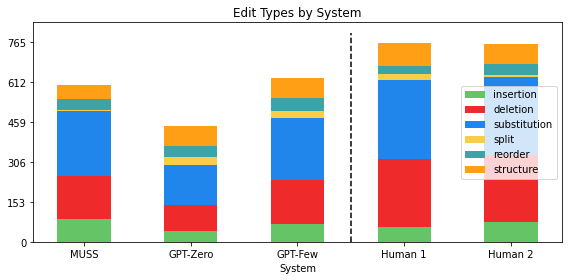

In [2]:
edit_type_by_system(data)

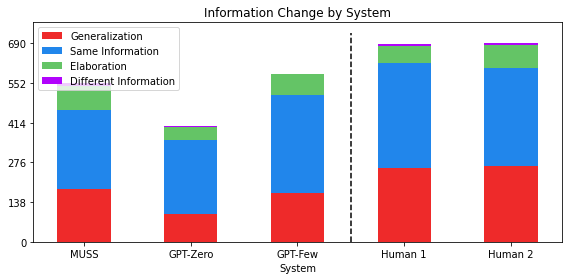

In [3]:
system_by_information_change(data)

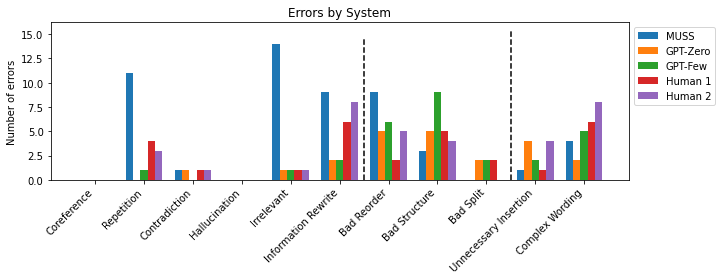

In [4]:
errors_by_system(data)

In [5]:
sankey_combined(data)

In [6]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

GPT-Few 	 8.68
Human 1 	 9.02
MUSS 	 3.46
GPT-Zero 	 5.69
Human 2 	 10.46


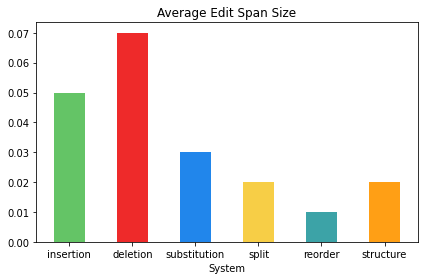

In [7]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

In [34]:
def get_annotations_by_edit_family(data, edit_type):
    information_change = None
    if edit_type == 'paraphrase':
        family = Family.LEXICAL
        edit_type = 'substitution'
    elif edit_type == 'split' or edit_type == 'structure' or edit_type == 'reorder':
        family = Family.SYNTAX
    elif edit_type == 'elaboration' or edit_type == 'generalization':
        family = Family.CONTENT
        if edit_type == 'elaboration':
            information_change = Information.MORE
        elif edit_type == 'generalization':
            information_change = Information.LESS
    else:
        raise ValueError(f'Edit type not supported for this operation: {edit_type}')

    anns = [ann for sent in data for ann in sent['processed_annotations']]
    selected = [ann for ann in anns if ann['family'] == family and ann['edit_type'] == edit_type]
    if edit_type == 'elaboration' or edit_type == 'generalization':
        selected = [ann for ann in anns if ann['information_impact'] == information_change]

    return selected

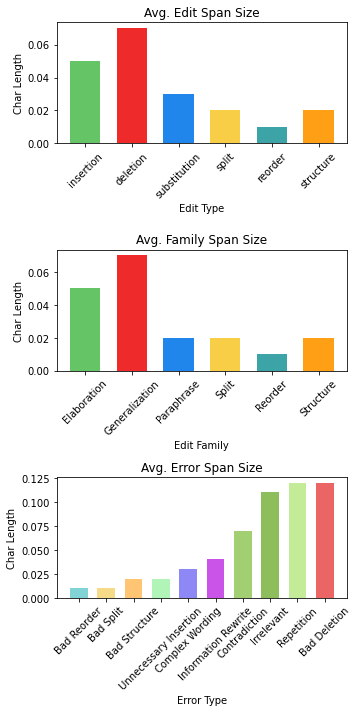

In [77]:
families = [
    'elaboration',
    'generalization',
    'paraphrase',
    'split',
    'reorder',
    'structure',
]

class Tmp(Enum):
    NO_ERROR = 'No Error'

width = 0.65
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
fig, ax = plt.subplots(3, 1, figsize=(5, 10))

edit_size = [avg([x['size'] for x in annotations if x['edit_type'] == edit_type]) for edit_type in edit_type_labels]
ax[0].bar(edit_type_labels, edit_size, width, color=[color_mapping[label] for label in edit_type_labels])

fam_size = [avg([x['size'] for x in get_annotations_by_edit_family(data, family)]) for family in families]
ax[1].bar([x.capitalize() for x in families], fam_size, width, color=[color_mapping[label] for label in families])

anns = [ann for sent in data for ann in sent['processed_annotations']]
error_segmentation = {}
for error in Error:
    error_segmentation[error] = [a for a in anns if error == a['error_type']]
error_segmentation[Tmp.NO_ERROR] = [a for a in anns if error == None]
pts = []
pts += [(error, avg([s['size'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])
ax[2].bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[color_mapping[label] for label in [p[0] for p in pts]])

ax[0].set_xlabel('Edit Type')
ax[1].set_xlabel('Edit Family')
ax[2].set_xlabel('Error Type')

ax[0].set_ylabel('Char Length')
ax[1].set_ylabel('Char Length')
ax[2].set_ylabel('Char Length')

ax[0].set_title('Avg. Edit Span Size')
ax[1].set_title('Avg. Family Span Size')
ax[2].set_title('Avg. Error Span Size')

for tick in ax[0].get_xticklabels() + ax[1].get_xticklabels() + ax[2].get_xticklabels():
    tick.set_rotation(45)
plt.show()

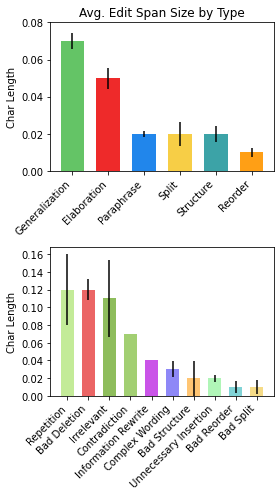

In [110]:
families = [
    'elaboration',
    'generalization',
    'paraphrase',
    'split',
    'reorder',
    'structure',
]

class Tmp(Enum):
    NO_ERROR = 'No Error'

import scipy.stats as st
def ci(int_data):
    y1, y2 = st.t.interval(alpha=0.95, df=len(int_data)-1, loc=np.mean(int_data), scale=st.sem(int_data)) 
    # If it's too big, we just won't even return it
    if y1 <= 0.001 or math.isnan(y1):
        return 0
    return (y2-y1) / 2

width = 0.65
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
fig, ax = plt.subplots(2, 1, figsize=(4, 7))

fam_size = [(family, avg([x['size'] for x in get_annotations_by_edit_family(data, family)]), ci([x['size'] for x in get_annotations_by_edit_family(data, family)])) for family in families]
pts = sorted([p for p in fam_size if p[1] != 0], key=lambda x: x[1], reverse=True)
ax[0].bar([p[0].capitalize() for p in pts], [p[1] for p in pts], width, yerr=[p[2] for p in pts], color=[color_mapping[label] for label in families])

anns = [ann for sent in data for ann in sent['processed_annotations']]
error_segmentation = {}
for error in Error:
    error_segmentation[error] = [a for a in anns if error == a['error_type']]
error_segmentation[Tmp.NO_ERROR] = [a for a in anns if error == None]
pts = [(error, avg([s['size'] for s in error_segmentation[error]]), ci([s['size'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1], reverse=True)
ax[1].bar([p[0].value for p in pts], [p[1] for p in pts], width, yerr=[p[2] for p in pts], color=[color_mapping[label] for label in [p[0] for p in pts]])

# ax[0].set_xlabel('Edit Family')
# ax[1].set_xlabel('Error Type')

ax[0].set_ylabel('Char Length')
ax[1].set_ylabel('Char Length')

ax[0].set_title('Avg. Edit Span Size by Type')
# ax[1].set_title('Avg. Error Span Size')

ax[0].set_yticks(np.arange(0, 0.085, 0.02))
ax[1].set_yticks(np.arange(0, 0.17, 0.02))

for tick in ax[0].get_xticklabels() + ax[1].get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
plt.show()

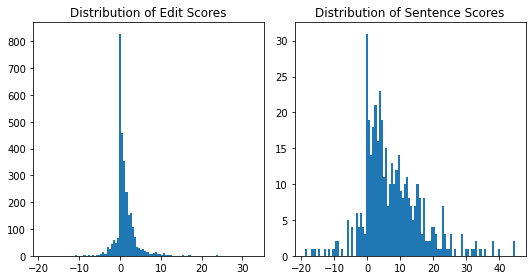

In [8]:
# Show the distribution of edit and sentence scores
score_distribution(data)

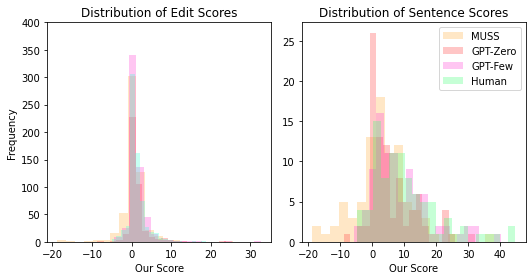

In [175]:
import random

n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True)

for system in [s for s in all_system_labels if s in systems and 'Human' not in s]:
    annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if sent['system'] == system] for x in y], key=lambda x: x['score'])
    axs[0].hist([x['score'] for x in annotations], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])
    axs[1].hist([x['score'] for x in data if x['system'] == system], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])

# Only human annotations
annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if 'Human' in sent['system']] for x in y], key=lambda x: x['score'])
edit_scores, sent_scores = [x['score'] for x in annotations], [x['score'] for x in data if 'Human' in x['system']]
axs[0].hist(random.sample(edit_scores, int(len(edit_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 1 Writing'])
axs[1].hist(random.sample(sent_scores, int(len(sent_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])

axs[0].set_yticks(np.arange(0, 401, 50))
axs[1].set_yticks(np.arange(0, 26, 5))

axs[0].set_title("Distribution of Edit Scores")
axs[1].set_title("Distribution of Sentence Scores")

axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Our Score")
axs[1].set_xlabel("Our Score")

axs[1].legend()

fig.show()


In [163]:
import random



[92, 47, 60, 51, 76]

In [9]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
vishnesh - Batch 6, HIT 32 (ID 130) - 44.74048122070516
vinayak - Batch 6, HIT 16 (ID 45) - 44.49183097534004
anton - Batch 5, HIT 40 (ID 39) - 40.218971182996725
vinayak - Batch 5, HIT 7 (ID 95) - 38.370866195271674
kelly - Batch 5, HIT 16 (ID 42) - 38.017761293449254

Lowest scoring:
anton - Batch 5, HIT 29 (ID 28) - -18.858700167805132
anton - Batch 6, HIT 16 (ID 114) - -16.69249648750433
anton - Batch 5, HIT 25 (ID 24) - -15.77741900496934
ayush - Batch 6, HIT 2 (ID 135) - -14.600727188758242
anton - Batch 6, HIT 29 (ID 127) - -12.7650672868958


In [10]:
# Get setences with a score of 0
zeros = zero_scoring_sents(data)

anton - Batch 5, HIT 19 (ID 18)
ayush - Batch 5, HIT 14 (ID 18)
vinayak - Batch 6, HIT 10 (ID 72)


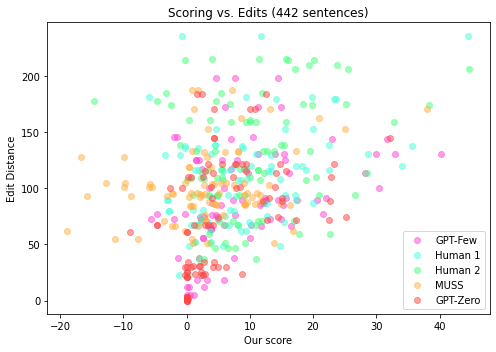

In [177]:
# average_scores: Averages our scores before plotting
edit_length(data, systems, simpeval=False, average_scores=False)

In [12]:
# Get sentences with at least 1 structure change from 1 annotator
ids = sorted(list(set([sent['id'] for sent in data if 'structure' in [x['type'] for x in sent['edits']]])))
print(f'Sentences with at least 1 structure change: {len(ids)} / {len(data)}')

Sentences with at least 1 structure change: 113 / 442


anton - Batch 5, HIT 6 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.

rachel - Batch 5, HIT 8 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.



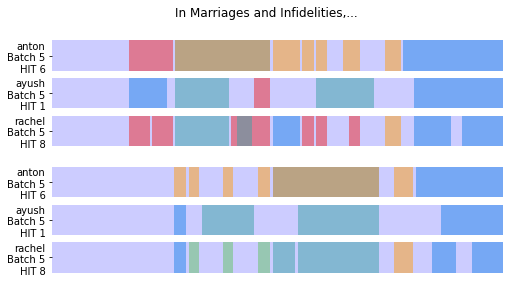

In [13]:
# Display a sentence with a structure change
id_ = 4
sents = [sent for sent in data if sent['id'] == ids[id_]]
print_changes(sents)
draw_agreement(sents)

In [14]:
for system in systems:
    aloe, aloe_no_del, perc_error = error_rate([sent for sent in data if system == sent['system']])
    print(f'''
    --- {system} ---
    Sentences with at least 1 error: {aloe}
    Sentences with at least 1 error excluding bad deletion: {aloe_no_del}
    Percentage of error edits: {perc_error}
    ''')


    --- new-wiki-1/GPT-3-few-shot ---
    Sentences with at least 1 error: 0.4111111111111111
    Sentences with at least 1 error excluding bad deletion: 0.24444444444444444
    Percentage of error edits: 0.09572649572649573
    

    --- new-wiki-1/Human 1 Writing ---
    Sentences with at least 1 error: 0.5111111111111111
    Sentences with at least 1 error excluding bad deletion: 0.26666666666666666
    Percentage of error edits: 0.11773255813953488
    

    --- new-wiki-1/Muss ---
    Sentences with at least 1 error: 0.8045977011494253
    Sentences with at least 1 error excluding bad deletion: 0.5057471264367817
    Percentage of error edits: 0.22644927536231885
    

    --- new-wiki-1/GPT-3-zero-shot ---
    Sentences with at least 1 error: 0.3448275862068966
    Sentences with at least 1 error excluding bad deletion: 0.19540229885057472
    Percentage of error edits: 0.09975062344139651
    

    --- new-wiki-1/Human 2 Writing ---
    Sentences with at least 1 error: 0.545454

In [15]:
# What % content edits are elaboration vs generalization

# Graphs each system with 6 columns each. Each column is a different quality edit. 
# This takes the average rating of each edit

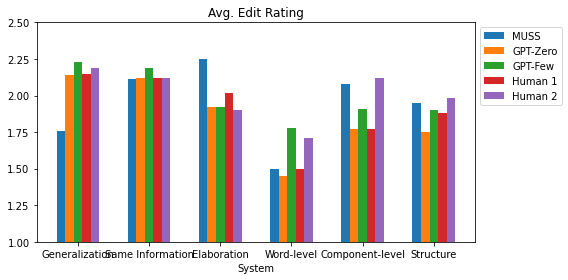

In [16]:
avg_edit_ratings(data)

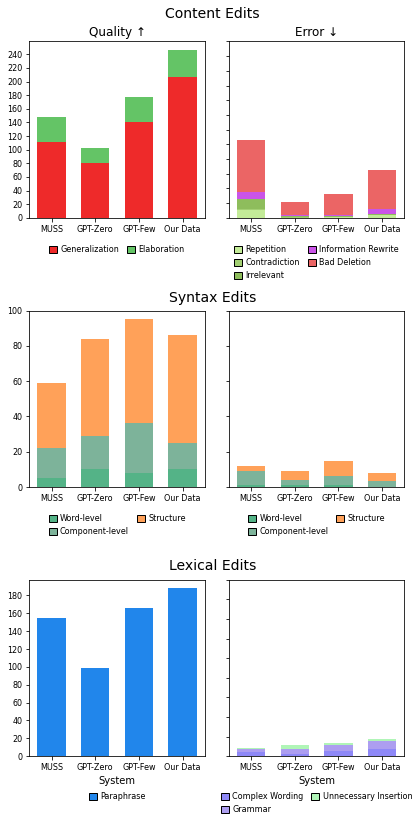

In [17]:
# Older version which combines graphs side-by-side
# edits_by_family(data)

# edits_by_family(data, Family.CONTENT)
# edits_by_family(data, Family.SYNTAX)
# edits_by_family(data, Family.LEXICAL)

edits_by_family_separated(data, savefig=True)
edits_by_family_separated(data)

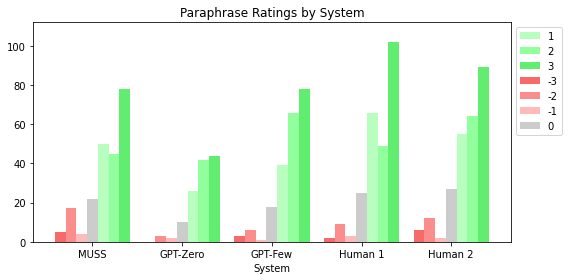

In [18]:
ratings_by_edit_type(data, 'paraphrase')
# ratings_by_edit_type(data, 'split')
# ratings_by_edit_type(data, 'reorder')
# ratings_by_edit_type(data, 'structure')

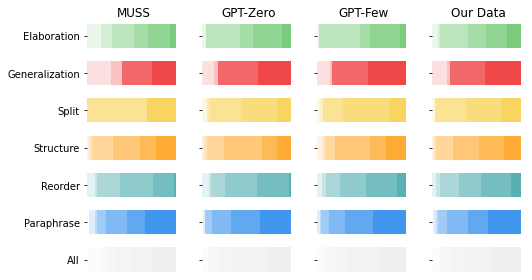

In [19]:
edit_ratings_barh(data, old_formatting=True)

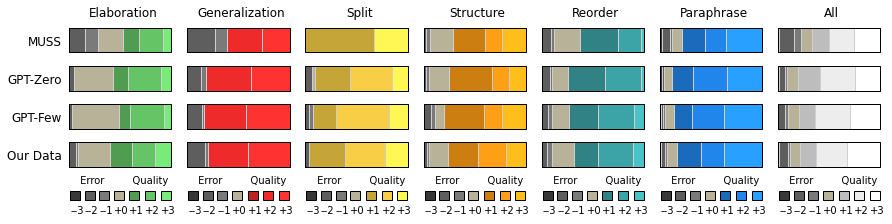

In [20]:
edit_ratings_barh(data) # include_all=False

In [21]:
# Prints a table quality edits
for family in ['elaboration', 'generalization', 'split', 'structure', 'reorder', 'paraphrase']:
    ratings = get_ratings_by_edit_type(data, family)
    al = f'{family} & '
    for system in [s for s in all_system_labels if s in ratings.keys() and '2' not in s]:
        total = sum([x if type(x) is int else sum(x.values()) for x in list(ratings[system].values())])
        nl = ""
        for i in range(3):
            nl += (f'{round(ratings[system]["error"][i] / total, 2)*100:.0f} & ')
        nl += (f'{round(ratings[system]["trivial"] / total, 2)*100:.0f} & ')
        for i in range(3):
            nl += (f'{round(ratings[system]["quality"][i] / total, 2)*100:.0f} & ')
        al += nl
    al = ' & ' + al[:-2].capitalize() + '\\tabularnewline'
    print(al)

 & Elaboration & 0 & 15 & 13 & 24 & 15 & 24 & 8 & 0 & 5 & 0 & 38 & 15 & 33 & 10 & 0 & 3 & 0 & 46 & 11 & 33 & 7 & 0 & 10 & 2 & 28 & 18 & 23 & 18 \tabularnewline
 & Generalization & 0 & 27 & 12 & 0 & 0 & 34 & 27 & 0 & 13 & 5 & 0 & 0 & 44 & 38 & 0 & 14 & 2 & 0 & 0 & 41 & 42 & 0 & 17 & 3 & 0 & 0 & 41 & 39 \tabularnewline
 & Split & 0 & 0 & 0 & 0 & 67 & 0 & 33 & 0 & 6 & 0 & 3 & 34 & 41 & 16 & 0 & 4 & 4 & 0 & 22 & 52 & 19 & 0 & 4 & 0 & 0 & 35 & 48 & 13 \tabularnewline
 & Structure & 0 & 2 & 4 & 23 & 31 & 17 & 23 & 0 & 3 & 3 & 19 & 42 & 16 & 16 & 0 & 7 & 4 & 9 & 39 & 18 & 23 & 0 & 3 & 1 & 17 & 28 & 36 & 14 \tabularnewline
 & Reorder & 0 & 9 & 3 & 26 & 37 & 23 & 3 & 0 & 8 & 3 & 15 & 36 & 36 & 3 & 0 & 6 & 4 & 16 & 29 & 35 & 10 & 0 & 3 & 3 & 37 & 30 & 20 & 7 \tabularnewline
 & Paraphrase & 2 & 8 & 2 & 10 & 23 & 20 & 35 & 2 & 2 & 0 & 8 & 20 & 33 & 35 & 0 & 3 & 1 & 9 & 18 & 31 & 37 & 1 & 4 & 1 & 10 & 26 & 19 & 40 \tabularnewline


In [22]:
# - Average quality edit (or log-size * average) rating for these modification types
#     - Content, Syntax, Lexical
#     - Elaboration, Generalization, Paraphrase, Structure, Reorder, Split
# - Average error edit for Content, Syntax, Lexical i guess?
# - Overlap the annotator’s decision for each system

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json', '../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vinayak', 'ayush', 'vishnesh', 'kelly', 'anton', 'rachel'}

anton - Batch 5, HIT 38 (ID 177) has 2 deletion edits but 1 annotations. Likely 

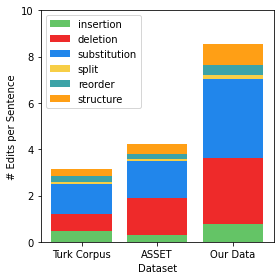

In [23]:
all_data = load_data('../annotated', preprocess=True)
edit_type_by_system(all_data, humans=True, normalized=True)